In [10]:
import h5py
import numpy as np
import math, tqdm, sys, os
import os
import matplotlib.pyplot as plt
import imageio

import torch
import torch.nn.modules as nn
import torch.optim as optim

from train import UNet, rgbd_dataset

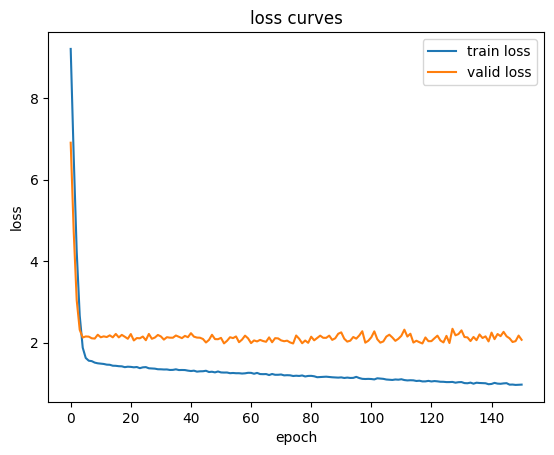

In [11]:
# show loss curve
train_loss_list = []
valid_loss_list = []
with open("train.log") as file:
    for line in file.readlines():
        if "Train Loss: " and "Valid Loss: " in line:
            train_loss = line.split("Train Loss: ")[1].split(",")[0]
            valid_loss = line.split("Valid Loss: ")[1]
            
            train_loss_list.append(float(train_loss))
            valid_loss_list.append(float(valid_loss))

plt.plot(train_loss_list, label="train loss")
plt.plot(valid_loss_list, label="valid loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss curves")
plt.legend()


In [12]:
# load the dataset from .mat file
print("loading dataset, waiting...")
with h5py.File('nyu_depth_v2_labeled.mat', 'r') as f:
    images = f['images'][:]
    depths = f['depths'][:]
print("image: ", images.shape)
print("depths: ", depths.shape)

# create dataset
# split the whole dataset into two parts: training and validation
test_num = 200
train_dataset = rgbd_dataset(images[test_num:], depths[test_num:])
valid_dataset = rgbd_dataset(images[:test_num], depths[:test_num])
# create dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=False)

loading dataset, waiting...
image:  (1449, 3, 640, 480)
depths:  (1449, 640, 480)


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
checkpoint = torch.load("./checkpoint/epoch_149.pth")
model.load_state_dict(checkpoint)
print("Model weights loaded.")

Model weights loaded.


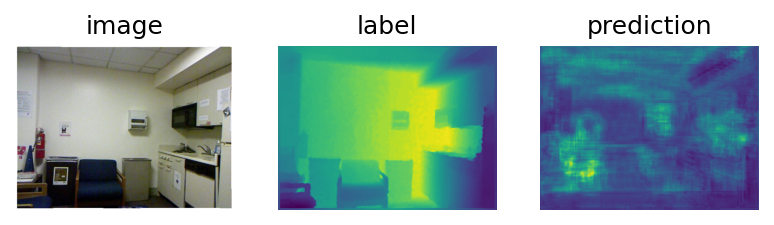

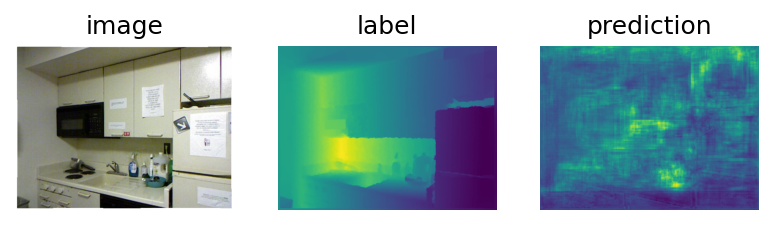

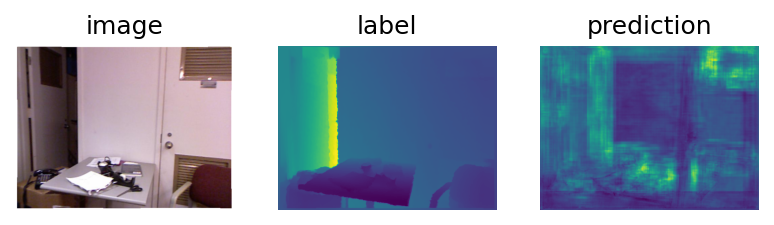

In [16]:
# show first 3 items in test-dataset
# image 0, image 1, image 2
for i in range(3):
    image, label = valid_dataset[i]
    image, label = image.unsqueeze(0).to(device), label.unsqueeze(0).to(device)
    image, label = image.to(device), label.to(device)
    prediction = model(image)

    # visualization
    image = image.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
    prediction = prediction.detach().cpu().numpy()
    
    single_image = image[0].transpose(1, 2, 0).transpose(1, 0, 2)
    single_label = label[0][0].transpose(1, 0)
    single_prediction = prediction[0][0].transpose(1, 0)
    
    plt.figure(dpi=150)
    plt.subplot(1, 3, 1); plt.axis('off'); plt.title("image")
    plt.imshow(single_image)
    plt.subplot(1, 3, 2); plt.axis('off'); plt.title("label")
    plt.imshow(single_label)
    plt.subplot(1, 3, 3); plt.axis('off'); plt.title("prediction")
    plt.imshow(single_prediction)